# Preliminary

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GRU, BatchNormalization, Flatten
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as pl
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns


In [16]:
df = pd.read_csv('data/player_stats.csv')
df = df.sort_values(by=['player_id', 'season', 'week'])


# EDA

In [17]:
df.dtypes 



player_id                       object
player_name                     object
player_display_name             object
position                        object
position_group                  object
headshot_url                    object
recent_team                     object
season                           int64
week                             int64
season_type                     object
opponent_team                   object
completions                      int64
attempts                         int64
passing_yards                    int64
passing_tds                      int64
interceptions                    int64
sacks                            int64
sack_yards                       int64
sack_fumbles                     int64
sack_fumbles_lost                int64
passing_air_yards                int64
passing_yards_after_catch        int64
passing_first_downs              int64
passing_epa                    float64
passing_2pt_conversions          int64
pacr                     

In [18]:
df

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr,years_in_league,years_played
0,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,MIA,1999,1,REG,...,0,0.000000,0.052632,NaN,NaN,0,12.7,13.7,1.0,0
1,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,MIA,1999,2,REG,...,0,0.000000,0.117647,NaN,NaN,0,5.1,8.1,1.0,0
2,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,MIA,1999,4,REG,...,0,NaN,0.023810,NaN,NaN,0,0.2,0.2,1.0,0
3,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,CLE,1999,7,REG,...,0,0.000000,0.050000,NaN,NaN,0,3.5,5.5,1.0,0
4,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,CLE,1999,8,REG,...,0,NaN,NaN,NaN,NaN,0,3.9,3.9,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128868,00-0039165,Z.Charbonnet,Zach Charbonnet,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SEA,2023,14,REG,...,0,-0.666667,0.032258,-0.025532,0.030515,0,4.8,5.8,1.0,0
128869,00-0039165,Z.Charbonnet,Zach Charbonnet,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SEA,2023,15,REG,...,0,0.000000,0.031250,0.012658,0.055736,0,1.6,1.6,1.0,0
128870,00-0039165,Z.Charbonnet,Zach Charbonnet,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SEA,2023,16,REG,...,0,0.307692,0.055556,-0.056034,0.044109,0,-0.4,0.6,1.0,0
128871,00-0039165,Z.Charbonnet,Zach Charbonnet,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SEA,2023,17,REG,...,0,3.000000,0.151515,0.057778,0.267717,0,4.1,9.1,1.0,0


In [19]:
df.isnull().sum(axis=0)

player_id                           0
player_name                     67380
player_display_name                 3
position                           72
position_group                     72
headshot_url                    59092
recent_team                         0
season                              0
week                                0
season_type                         0
opponent_team                       0
completions                         0
attempts                            0
passing_yards                       0
passing_tds                         0
interceptions                       0
sacks                               0
sack_yards                          0
sack_fumbles                        0
sack_fumbles_lost                   0
passing_air_yards                   0
passing_yards_after_catch           0
passing_first_downs                 0
passing_epa                    112406
passing_2pt_conversions             0
pacr                           112846
dakota      

# Feature Engineering


- Trend analysis
- Week-to-week consistency/variability
    - standard deviation of weekly totals
- Rolling averages of last n weeks/years
- Years in league = season - player's first season

In [20]:
# Rolling averages of last n years

# Years in league
# for each unique player id, get the number of years they have been in the league
# Years in league
df['years_played'] = df.groupby('player_id')['season'].rank(method='dense')-1
df['years_played'] = df['years_played'].astype(int)

# Data cleaning

In [21]:
# Drop any rows with season="POST"
df = df[df['season_type'] != 'POST']

# Full df cleaning
df.drop(
    columns=[
        'headshot_url',
        'player_name',
        'player_display_name',
        'recent_team',
        'opponent_team',
        'position',
        'season_type'],
    inplace=True
)
target = 'fantasy_points_ppr'

df = pd.get_dummies(
    df,
    columns=['player_id','season']
)

# QB data cleaning
qb_df = df[df['position_group'] == 'QB'].copy()

qb_df = pd.get_dummies(
    qb_df,
    columns=['position_group']
)


qb_df.drop(
    columns=[
        'receiving_epa',
        'racr',
        'target_share',
        'air_yards_share',
        'wopr'
    ], inplace=True
)
qb_df.dropna(
    subset=[
        'passing_epa',
        'pacr',
        'dakota',
        'rushing_epa'
    ], inplace=True
)


qb_df_target = qb_df[target]
qb_df_features = qb_df.drop(columns=[target])




# RB data cleaning

rb_df = df[df['position_group'] == 'RB'].copy()

rb_df = pd.get_dummies(
    rb_df,
    columns=['position_group']
)

rb_df.drop(
    columns=[
        'passing_epa',
        'pacr',
        'dakota',
        'receiving_epa',
        'rushing_epa',
        'racr',
        'target_share',
        'air_yards_share',
        'wopr'
    ], inplace=True
)

rb_df_target = rb_df[target]
rb_df_features = rb_df.drop(columns=[target])



# WR data cleaning
wr_df = df[df['position_group'] == 'WR'].copy()

wr_df = pd.get_dummies(
    wr_df,
    columns=['position_group']
)

wr_df.drop(
    columns=[
        'passing_epa',
        'pacr',
        'dakota',
        'rushing_epa',
    ], inplace=True
)

wr_df.dropna(
    subset=[
        'receiving_epa',
        'racr',
        'target_share',
        'air_yards_share',
        'wopr'
    ], inplace=True
)


wr_df_target = wr_df[target]
wr_df_features = wr_df.drop(columns=[target])



# TE data cleaning
te_df = df[df['position_group'] == 'TE'].copy()

te_df = pd.get_dummies(
    te_df,
    columns=['position_group']
)

te_df.drop(
    columns=[
        'passing_epa',
        'pacr',
        'dakota',
        'rushing_epa',
    ], inplace=True
)

te_df.dropna(
    subset=[
        'receiving_epa',
        'racr',
        'target_share',
        'air_yards_share',
        'wopr'
    ], inplace=True
)

te_df_target = te_df[target]
te_df_features = te_df.drop(columns=[target])



#sequence_length = 4  # Example: 4 weeks of data
#X_qb, y_qb = create_sequences(np.hstack((qb_features, qb_target.reshape(-1, 1))), sequence_length)

/tmp/ipykernel_83349/932398287.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(


# Sequence generation

In [22]:
qb_df_features

,week,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,sack_fumbles_lost,...,season_2015,season_2016,season_2017,season_2018,season_2019,season_2020,season_2021,season_2022,season_2023,position_group_QB
44,1,27,48,355,5,3,1,7,0,0,...,False,False,False,False,False,False,False,False,False,True
45,2,9,21,101,0,2,2,11,0,0,...,False,False,False,False,False,False,False,False,False,True
46,4,14,19,186,2,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
47,5,21,38,177,1,2,1,7,0,0,...,False,False,False,False,False,False,False,False,False,True
48,6,19,31,260,0,1,3,16,0,0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128850,18,20,26,264,2,0,2,18,0,0,...,False,False,False,False,False,False,False,False,True,True
128853,1,24,37,223,1,1,4,8,0,0,...,False,False,False,False,False,False,False,False,True,True
128854,2,6,10,56,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,True
128855,4,11,25,200,2,0,2,4,0,0,...,False,False,False,False,False,False,False,False,True,True


In [23]:
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

In [24]:
sequence_length = 3  # 6 weeks of data, nominally. Note, this will not account for gaps in weeks due to injury, transition between seasons, etc.

qb_df_features_sequences, qb_df_target_sequences = create_sequences(qb_df_features.values, qb_df_target.values, sequence_length)
rb_df_features_sequences, rb_df_target_sequences = create_sequences(rb_df_features.values, rb_df_target.values, sequence_length)
wr_df_features_sequences, wr_df_target_sequences = create_sequences(wr_df_features.values, wr_df_target.values, sequence_length)
te_df_features_sequences, te_df_target_sequences = create_sequences(te_df_features.values, te_df_target.values, sequence_length)

In [25]:
qb_df_features_sequences.shape, qb_df_target_sequences.shape

((11717, 3, 4040), (11717,))

# Train/test time-series split, cross-validation, and 

In [26]:
X_qb = qb_df_features_sequences
y_qb = qb_df_target_sequences

X_rb = rb_df_features_sequences
y_rb = rb_df_target_sequences

X_wr = wr_df_features_sequences
y_wr = wr_df_target_sequences

X_te = te_df_features_sequences
y_te = te_df_target_sequences

tscv = TimeSeriesSplit(n_splits=5)


# Normalization

In [27]:
def normalize_sequences(X_train, X_test):
    scaler = StandardScaler()
    num_features = X_train.shape[2]
    
    X_train_reshaped = X_train.reshape(-1, num_features)
    X_test_reshaped = X_test.reshape(-1, num_features)
    
    scaler.fit(X_train_reshaped)
    
    X_train_normalized = scaler.transform(X_train_reshaped).reshape(X_train.shape)
    X_test_normalized = scaler.transform(X_test_reshaped).reshape(X_test.shape)
    
    return X_train_normalized, X_test_normalized

In [28]:
# Dictionaries to store the normalized datasets
normalized_datasets = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for X, y, key in [(X_qb, y_qb, 'qb'), 
                  (X_rb, y_rb, 'rb'), 
                  (X_wr, y_wr, 'wr'), 
                  (X_te, y_te, 'te')]:
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Normalize the sequences
        X_train_normalized, X_test_normalized = normalize_sequences(X_train, X_test)
        
        # Store the normalized datasets in the dictionary
        normalized_datasets[key].append({
            'X_train': X_train_normalized,
            'X_test': X_test_normalized,
            'y_train': y_train,
            'y_test': y_test
        })

# Output the normalized datasets
for key, datasets in normalized_datasets.items():
    print(f"Normalized datasets for {key}:")
    for i, dataset in enumerate(datasets):
        print(f"  Split {i + 1}:")
        print(f"    X_train shape: {dataset['X_train'].shape}")
        print(f"    X_test shape: {dataset['X_test'].shape}")
        print(f"    y_train shape: {dataset['y_train'].shape}")
        print(f"    y_test shape: {dataset['y_test'].shape}")

Normalized datasets for qb:
  Split 1:
    X_train shape: (1957, 3, 4040)
    X_test shape: (1952, 3, 4040)
    y_train shape: (1957,)
    y_test shape: (1952,)
  Split 2:
    X_train shape: (3909, 3, 4040)
    X_test shape: (1952, 3, 4040)
    y_train shape: (3909,)
    y_test shape: (1952,)
  Split 3:
    X_train shape: (5861, 3, 4040)
    X_test shape: (1952, 3, 4040)
    y_train shape: (5861,)
    y_test shape: (1952,)
  Split 4:
    X_train shape: (7813, 3, 4040)
    X_test shape: (1952, 3, 4040)
    y_train shape: (7813,)
    y_test shape: (1952,)
  Split 5:
    X_train shape: (9765, 3, 4040)
    X_test shape: (1952, 3, 4040)
    y_train shape: (9765,)
    y_test shape: (1952,)
Normalized datasets for rb:
  Split 1:
    X_train shape: (6141, 3, 4036)
    X_test shape: (6136, 3, 4036)
    y_train shape: (6141,)
    y_test shape: (6136,)
  Split 2:
    X_train shape: (12277, 3, 4036)
    X_test shape: (6136, 3, 4036)
    y_train shape: (12277,)
    y_test shape: (6136,)
  Split 3:


# Model building

### LSTM Model

In [31]:
def create_rnn_model(input_shape, units=50, num_lstm_layers=1, activation='tanh', recurrent_activation='sigmoid',
                     use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
                     bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
                     recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                     kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
                     dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False,
                     go_backwards=False, stateful=False, unroll=False):
    model = Sequential()
    
    for i in range(num_lstm_layers):
        # For the first layer, use input_shape
        if i == 0:
            model.add(LSTM(
                units=units,
                activation=activation,
                recurrent_activation=recurrent_activation,
                use_bias=use_bias,
                kernel_initializer=kernel_initializer,
                recurrent_initializer=recurrent_initializer,
                bias_initializer=bias_initializer,
                unit_forget_bias=unit_forget_bias,
                kernel_regularizer=kernel_regularizer,
                recurrent_regularizer=recurrent_regularizer,
                bias_regularizer=bias_regularizer,
                activity_regularizer=activity_regularizer,
                kernel_constraint=kernel_constraint,
                recurrent_constraint=recurrent_constraint,
                bias_constraint=bias_constraint,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                return_sequences=True,  # Typically return sequences for intermediate layers
                return_state=return_state,
                go_backwards=go_backwards,
                stateful=stateful,
                unroll=unroll,
                input_shape=input_shape
            ))
        else:
            model.add(LSTM(
                units=units,
                activation=activation,
                recurrent_activation=recurrent_activation,
                use_bias=use_bias,
                kernel_initializer=kernel_initializer,
                recurrent_initializer=recurrent_initializer,
                bias_initializer=bias_initializer,
                unit_forget_bias=unit_forget_bias,
                kernel_regularizer=kernel_regularizer,
                recurrent_regularizer=recurrent_regularizer,
                bias_regularizer=bias_regularizer,
                activity_regularizer=activity_regularizer,
                kernel_constraint=kernel_constraint,
                recurrent_constraint=recurrent_constraint,
                bias_constraint=bias_constraint,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                return_sequences=True,  # Return sequences for intermediate layers
                return_state=return_state,
                go_backwards=go_backwards,
                stateful=stateful,
                unroll=unroll
            ))

        # Dropout layer after each LSTM layer
        model.add(Dropout(dropout))
    
    # Final LSTM layer (return_sequences should be False for the last layer)
    model.add(LSTM(
        units=units,
        activation=activation,
        recurrent_activation=recurrent_activation,
        use_bias=use_bias,
        kernel_initializer=kernel_initializer,
        recurrent_initializer=recurrent_initializer,
        bias_initializer=bias_initializer,
        unit_forget_bias=unit_forget_bias,
        kernel_regularizer=kernel_regularizer,
        recurrent_regularizer=recurrent_regularizer,
        bias_regularizer=bias_regularizer,
        activity_regularizer=activity_regularizer,
        kernel_constraint=kernel_constraint,
        recurrent_constraint=recurrent_constraint,
        bias_constraint=bias_constraint,
        dropout=dropout,
        recurrent_dropout=recurrent_dropout,
        return_sequences=False,  # Do not return sequences for the last LSTM layer
        return_state=return_state,
        go_backwards=go_backwards,
        stateful=stateful,
        unroll=unroll
    ))

    # Output layer for regression
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

### GRU Model

In [ ]:
def build_gru_model(
    input_shape,
    units,
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    seed=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    reset_after=True,
    use_cudnn="auto",
    **kwargs
):
    model = Sequential()
    
    # Add GRU layer
    model.add(GRU(
        units=units,
        activation=activation,
        recurrent_activation=recurrent_activation,
        use_bias=use_bias,
        kernel_initializer=kernel_initializer,
        recurrent_initializer=recurrent_initializer,
        bias_initializer=bias_initializer,
        kernel_regularizer=kernel_regularizer,
        recurrent_regularizer=recurrent_regularizer,
        bias_regularizer=bias_regularizer,
        activity_regularizer=activity_regularizer,
        kernel_constraint=kernel_constraint,
        recurrent_constraint=recurrent_constraint,
        bias_constraint=bias_constraint,
        dropout=dropout,
        recurrent_dropout=recurrent_dropout,
        return_sequences=return_sequences,
        return_state=return_state,
        go_backwards=go_backwards,
        stateful=stateful,
        unroll=unroll,
        reset_after=reset_after,
        use_cudnn=use_cudnn,
        input_shape=input_shape,
        **kwargs
    ))
    
    # Example: Add another GRU layer if return_sequences=True
    if return_sequences:
        model.add(GRU(units=units // 2, return_sequences=False))
    
    # Example: Add a Dense layer
    model.add(Dense(units=64, activation='relu'))
    
    # Example: Add a Dropout layer
    model.add(Dropout(rate=0.5))
    
    # Example: Add Batch Normalization
    model.add(BatchNormalization())
    
    # Example: Add a final output layer (regression case)
    model.add(Dense(units=1, activation='linear'))
    
    return model


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor
    patience=4,                # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best metric value
)

# Training

### LSTM

In [32]:
# run the model on the normalized datasets
rnn_models_lstm = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, datasets in normalized_datasets.items():
    for i, dataset in enumerate(datasets):
        print(f"Training RNN model for {key} - split {i + 1}...")
        
        # Get the input shape
        input_shape = dataset['X_train'].shape[1:]
        
        # Create the RNN model
        model = create_rnn_model(input_shape, num_lstm_layers=4)
        
        # Train the model
        model.fit(
            dataset['X_train'],
            dataset['y_train'],
            epochs=10,
            batch_size=32,
            validation_data=(dataset['X_test'], dataset['y_test']),
            verbose=1,
            callbacks=[early_stopping]
        )
        
        # Store the model
        rnn_models[key].append(model)

Training RNN model for qb - split 1...


/home/calder/Documents/ff2024/ff24/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


2024-08-26 21:47:33.416642: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 199.3497 - val_loss: 81.7325
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 61.5919 - val_loss: 70.2740
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 57.2527 - val_loss: 69.7197
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 54.3855 - val_loss: 69.6792
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 56.9522 - val_loss: 74.6962
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 52.0368 - val_loss: 77.6886
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 49.1758 - val_loss: 74.0363
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 50.1975 - val_loss: 77.0945
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 48.2930 - val_loss: 81.8790
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 48.6850 - val_loss: 75.5658
Training RNN model for qb - split 2...
Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 172.2331 - val_loss: 63.5555
Epoch 2/10
123/123 

2024-08-26 21:50:46.508735: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1188957168 exceeds 10% of free system memory.
2024-08-26 21:50:47.546375: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1188957168 exceeds 10% of free system memory.


Epoch 1/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 62.3087 - val_loss: 47.8631
Epoch 2/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 39.9189 - val_loss: 47.7859
Epoch 3/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 36.4208 - val_loss: 47.4188
Epoch 4/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 36.9144 - val_loss: 51.3059
Epoch 5/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 35.3699 - val_loss: 59.6839
Epoch 6/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 32.2328 - val_loss: 60.7568
Epoch 7/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 29.5145 - val_loss: 56.5567
Epoch 8/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 26.4294 - val_loss: 64.2252
Epoch 9/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 24.5358 - val_loss: 63.6954
Epoch 10/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 21.4935 - val_loss: 68.8045
Training RNN model for rb - split 5...


2024-08-26 21:51:52.376595: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1486135920 exceeds 10% of free system memory.
2024-08-26 21:51:53.662843: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1486135920 exceeds 10% of free system memory.


Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 57.8797 - val_loss: 52.7435
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 39.6866 - val_loss: 54.7817
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 36.8499 - val_loss: 56.2194
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 35.2272 - val_loss: 55.0378
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 33.4142 - val_loss: 60.6260
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 31.3862 - val_loss: 59.6687
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 28.0809 - val_loss: 61.8661
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 24.6016 - val_loss: 65.7355
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 21.7963 - val_loss: 67.5549
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 19.4152 - val_loss: 71.4076
Training RNN model for wr - split 1...
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 102.7335 - val_los

2024-08-26 21:54:53.493164: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1106781408 exceeds 10% of free system memory.


Epoch 1/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 68.5210 - val_loss: 52.8034
Epoch 2/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 46.8397 - val_loss: 53.2369
Epoch 3/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 45.5722 - val_loss: 56.8091
Epoch 4/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 43.8932 - val_loss: 56.9421
Epoch 5/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 42.0073 - val_loss: 58.0990
Epoch 6/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 40.5093 - val_loss: 56.6891
Epoch 7/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 38.8640 - val_loss: 59.8417
Epoch 8/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 36.2496 - val_loss: 64.1393
Epoch 9/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 33.1657 - val_loss: 77.5614
Epoch 10/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 30.6429 - val_loss: 75.7240
Training RNN model for wr - split 5...
Epoch 1/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 65.7013 - val_loss: 

### GRU

In [ ]:
# run the model on the normalized datasets
rnn_models_gru = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, datasets in normalized_datasets.items():
    for i, dataset in enumerate(datasets):
        print(f"Training RNN model for {key} - split {i + 1}...")
        
        # Get the input shape
        input_shape = dataset['X_train'].shape[1:]
        
        # Create the RNN model
        model = build_gru_model(input_shape)
        
        # Train the model
        model.fit(
            dataset['X_train'],
            dataset['y_train'],
            epochs=10,
            batch_size=32,
            validation_data=(dataset['X_test'], dataset['y_test']),
            verbose=1,
            callbacks=[early_stopping]
        )
        
        # Store the model
        rnn_models_gru[key].append(model)

# Model tuning and cross-validation

# Testing

### LSTM

In [33]:
# Test the model on the test data
rnn_predictions_lstm = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, models in rnn_models.items():
    for i, model in enumerate(models):
        dataset = normalized_datasets[key][i]
        print(f"Testing RNN model for {key} - split {i + 1}...")
        
        # Make predictions
        y_pred = model.predict(dataset['X_test'])
        
        # Store the predictions
        rnn_predictions_lstm[key].append(y_pred)

# Output the predictions
for key, predictions in rnn_predictions_lstm.items():
    print(f"Predictions for {key}:")
    for i, prediction in enumerate(predictions):
        print(f"  Split {i + 1}:")
        print(f"    Shape: {prediction.shape}")
        

Testing RNN model for qb - split 1...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing RNN model for qb - split 2...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Testing RNN model for qb - split 3...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Testing RNN model for qb - split 4...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Testing RNN model for qb - split 5...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing RNN model for rb - split 1...
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing RNN model for rb - split 2...
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing RNN model for rb - split 3...
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Testing RNN model for rb - split 4...
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Testing RNN model for rb - split 5...
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing RNN model for wr - split 1...
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing RNN model for wr - split 2...
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Testing RNN model for wr - split 3...
179/179 ━━━━━━━━━━━━

### GRU

In [34]:
# Test the model on the test data
rnn_predictions_gru = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, models in rnn_models_gru.items():
    for i, model in enumerate(models):
        dataset = normalized_datasets[key][i]
        print(f"Testing RNN model for {key} - split {i + 1}...")
        
        # Make predictions
        y_pred = model.predict(dataset['X_test'])
        
        # Store the predictions
        rnn_predictions_gru[key].append(y_pred)

# Output the predictions
for key, predictions in rnn_predictions_gru.items():
    print(f"Predictions for {key}:")
    for i, prediction in enumerate(predictions):
        print(f"  Split {i + 1}:")
        print(f"    Shape: {prediction.shape}")
        

# Performance evaluation

#### RMSE
#### MAE

# Prediction

Evaluating RNN model for qb - split 1...


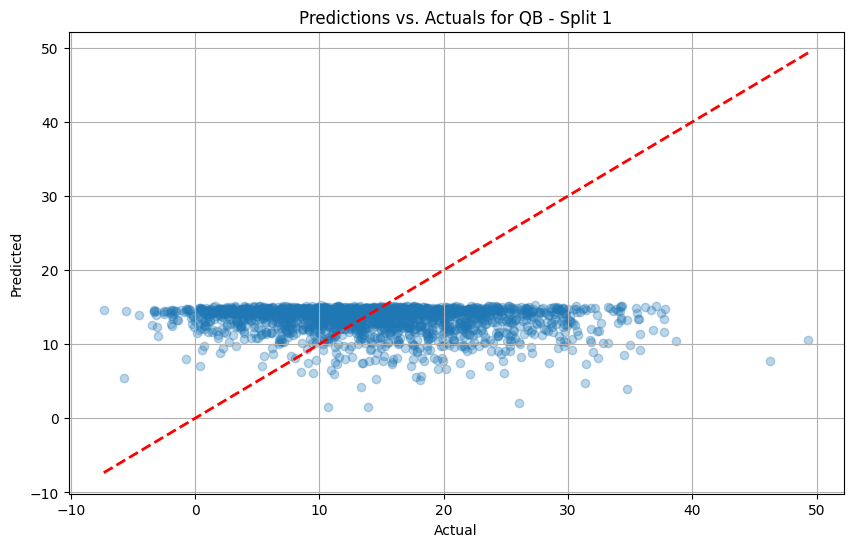

Mean Squared Error (MSE): 75.56583510591824
Mean Absolute Error (MAE): 6.9424293697466615
R² Score: -0.1167847357134848
Evaluating RNN model for qb - split 2...


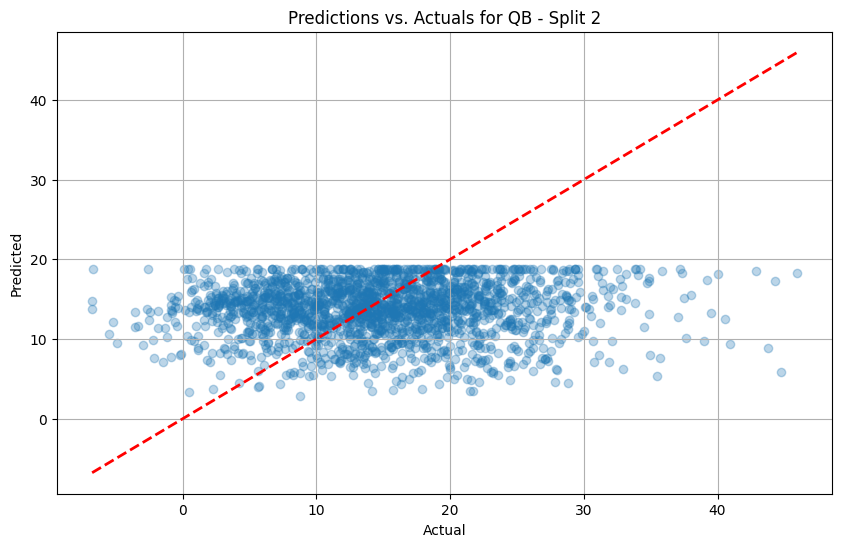

Mean Squared Error (MSE): 73.31742341363825
Mean Absolute Error (MAE): 6.7788278962451916
R² Score: -0.16246316056730215
Evaluating RNN model for qb - split 3...


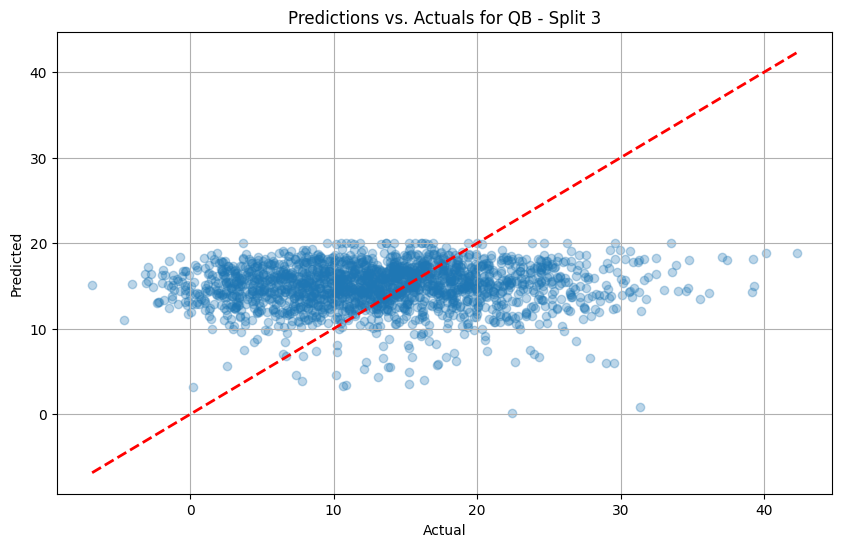

Mean Squared Error (MSE): 63.71761966998492
Mean Absolute Error (MAE): 6.414818828865336
R² Score: -0.1334521180882251
Evaluating RNN model for qb - split 4...


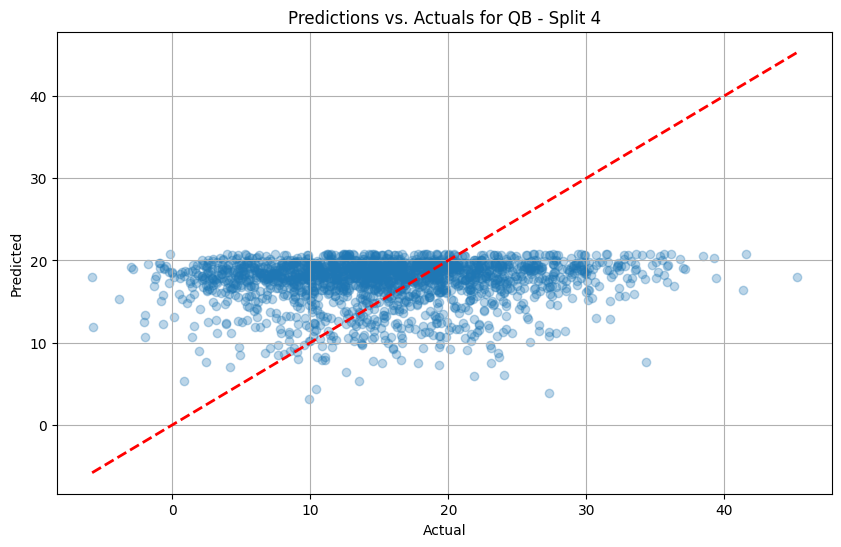

Mean Squared Error (MSE): 68.13528052139215
Mean Absolute Error (MAE): 6.676919854879379
R² Score: -0.13198867954418647
Evaluating RNN model for qb - split 5...


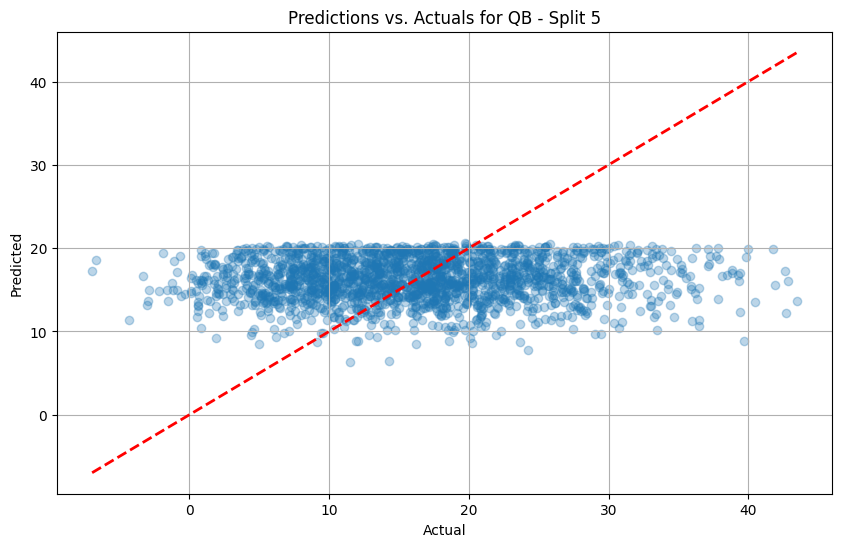

Mean Squared Error (MSE): 76.17231164977667
Mean Absolute Error (MAE): 7.023750864013297
R² Score: -0.06574583731557415
Evaluating RNN model for rb - split 1...


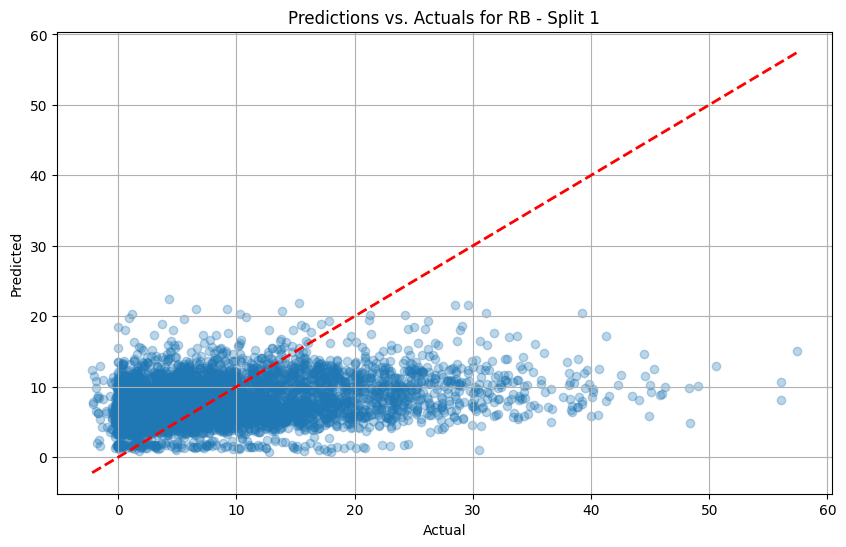

Mean Squared Error (MSE): 59.42895594287973
Mean Absolute Error (MAE): 5.7017195999917645
R² Score: 0.11575508343256946
Evaluating RNN model for rb - split 2...


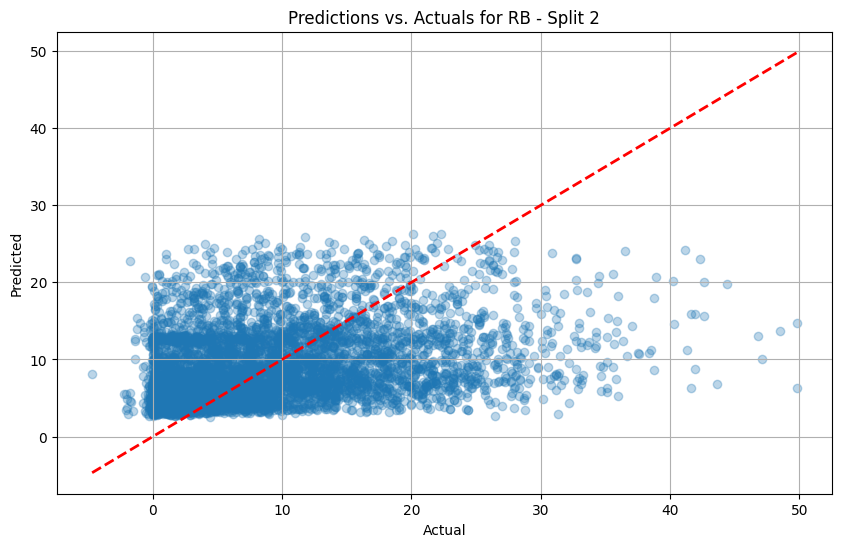

Mean Squared Error (MSE): 58.10653384897368
Mean Absolute Error (MAE): 5.732512984623965
R² Score: 0.07659532376536615
Evaluating RNN model for rb - split 3...


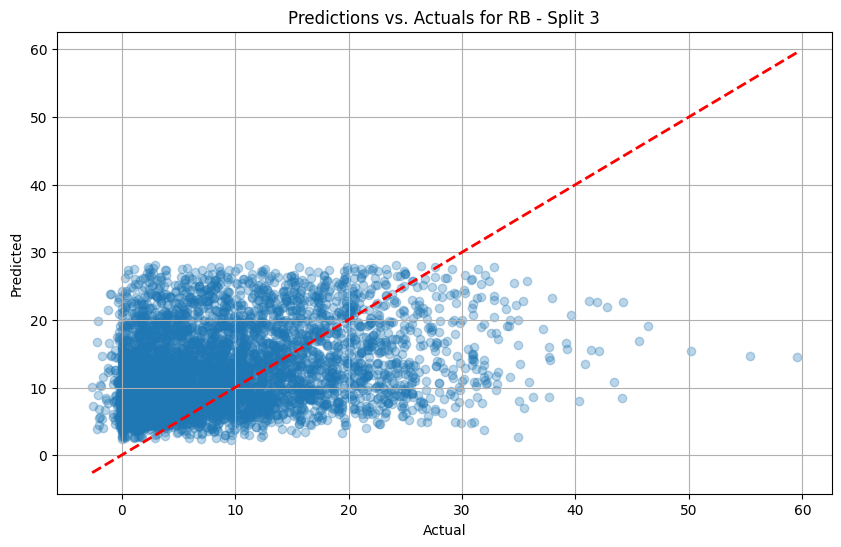

Mean Squared Error (MSE): 78.69561332301467
Mean Absolute Error (MAE): 7.191372800215282
R² Score: -0.30010556560377566
Evaluating RNN model for rb - split 4...


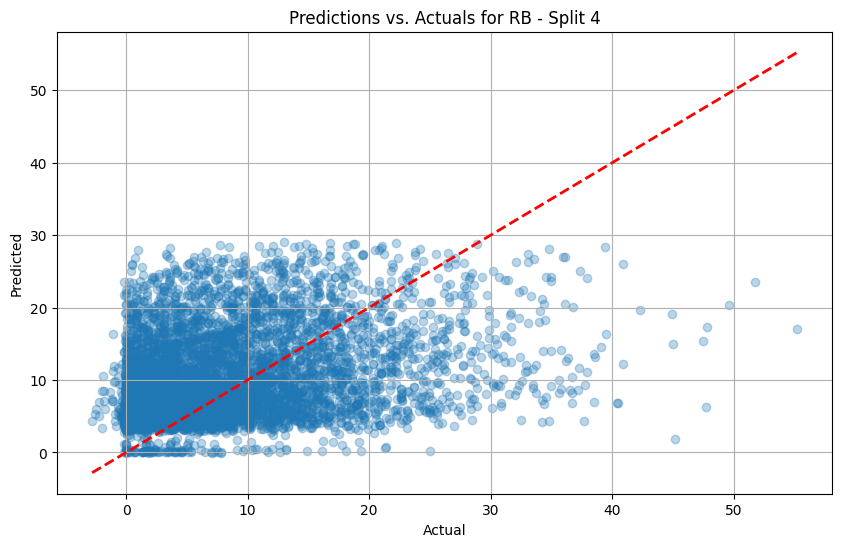

Mean Squared Error (MSE): 68.80455324091882
Mean Absolute Error (MAE): 6.431569709957344
R² Score: -0.17115961649006217
Evaluating RNN model for rb - split 5...


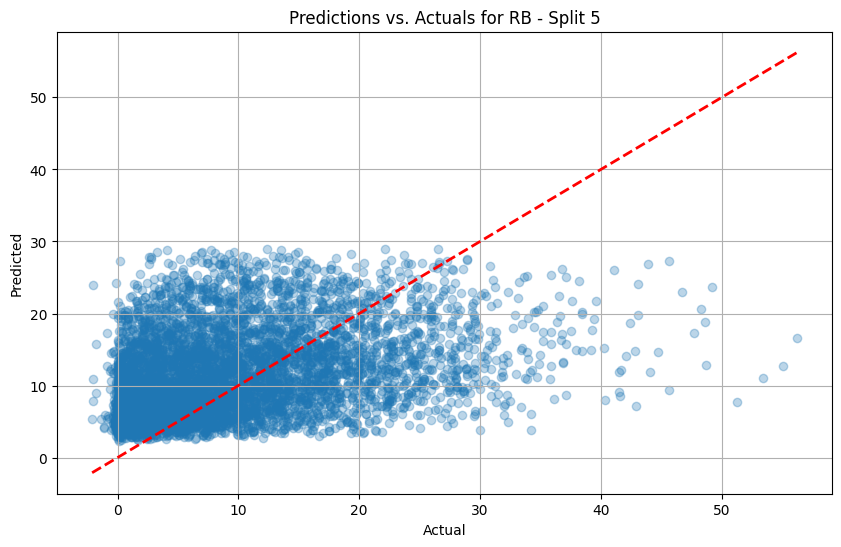

Mean Squared Error (MSE): 71.40764870474054
Mean Absolute Error (MAE): 6.573158106971751
R² Score: -0.034903688855949744
Evaluating RNN model for wr - split 1...


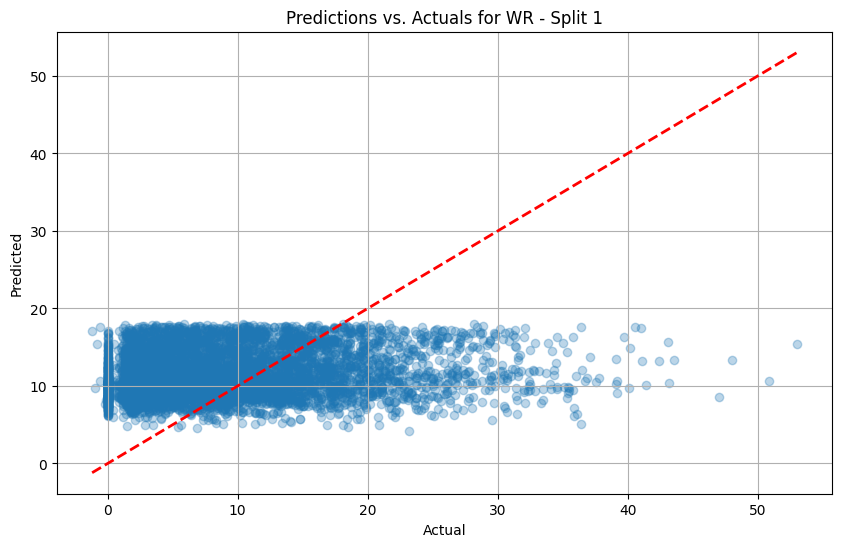

Mean Squared Error (MSE): 67.71854218810643
Mean Absolute Error (MAE): 6.819316464376333
R² Score: -0.14923379916900492
Evaluating RNN model for wr - split 2...


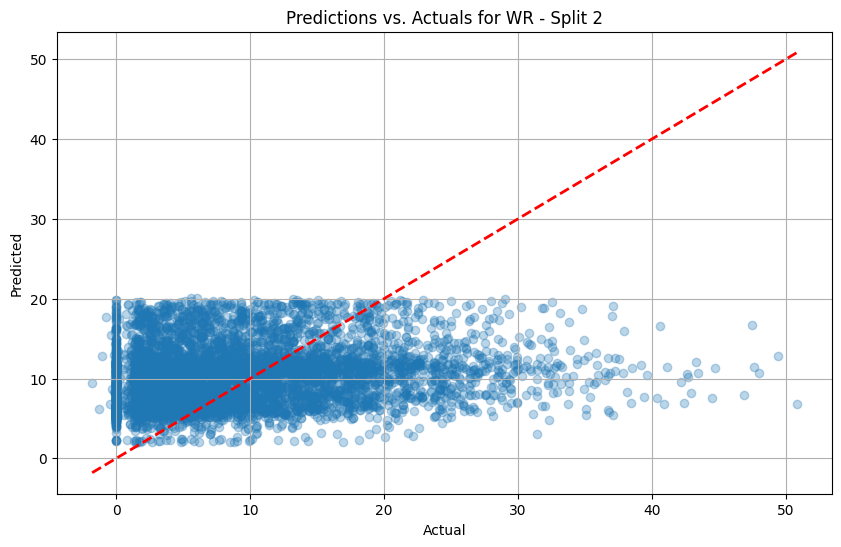

Mean Squared Error (MSE): 70.5035914724319
Mean Absolute Error (MAE): 6.687217584929048
R² Score: -0.0890741951132803
Evaluating RNN model for wr - split 3...


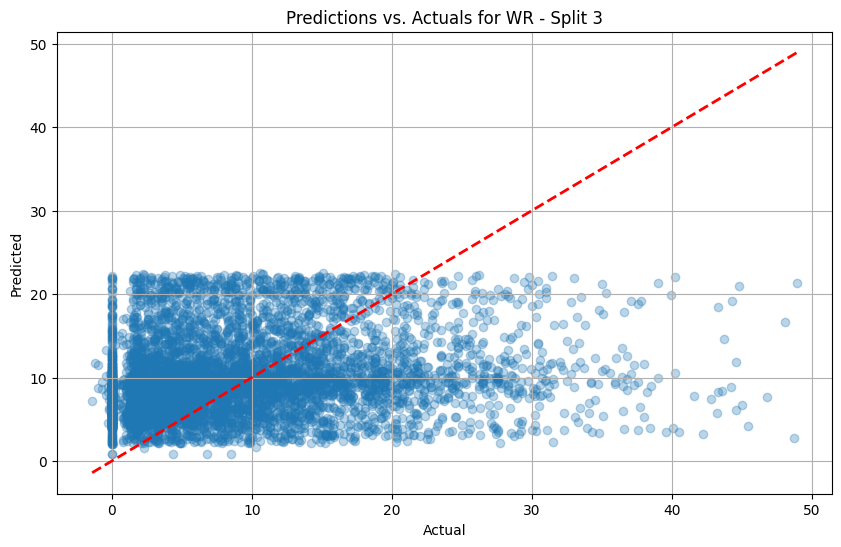

Mean Squared Error (MSE): 76.45059558575139
Mean Absolute Error (MAE): 6.779847996212331
R² Score: -0.17514732180851178
Evaluating RNN model for wr - split 4...


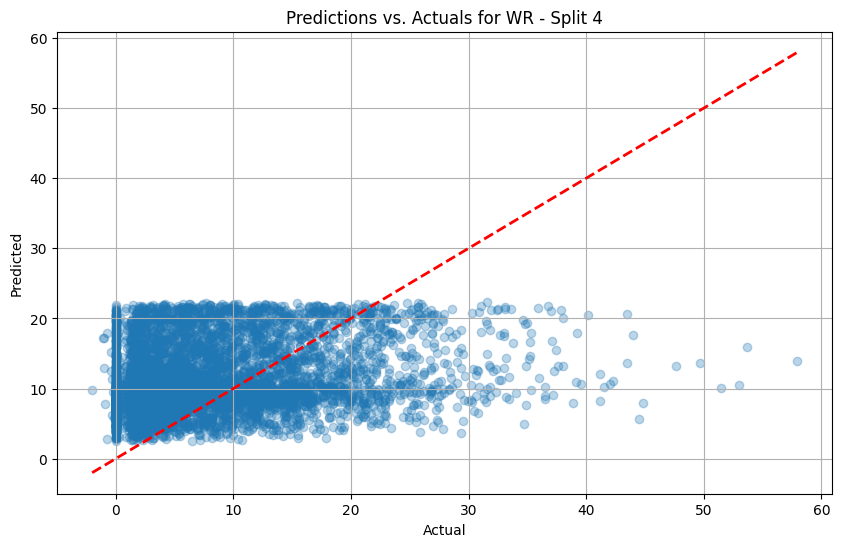

Mean Squared Error (MSE): 75.72393520228108
Mean Absolute Error (MAE): 7.061030421400754
R² Score: -0.29205726456138503
Evaluating RNN model for wr - split 5...


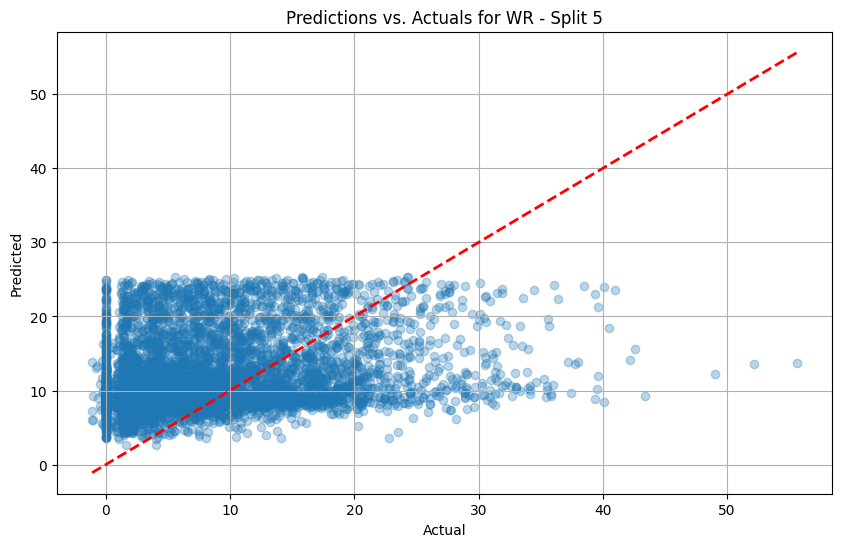

Mean Squared Error (MSE): 77.74975529970182
Mean Absolute Error (MAE): 7.210357280867249
R² Score: -0.3854779744309751
Evaluating RNN model for te - split 1...


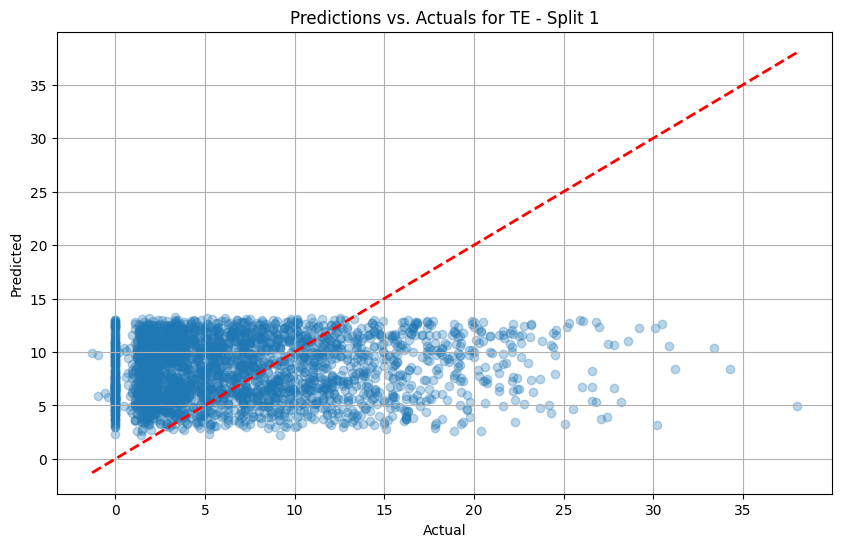

Mean Squared Error (MSE): 41.524099523097334
Mean Absolute Error (MAE): 5.319737538511523
R² Score: -0.21159160867104787
Evaluating RNN model for te - split 2...


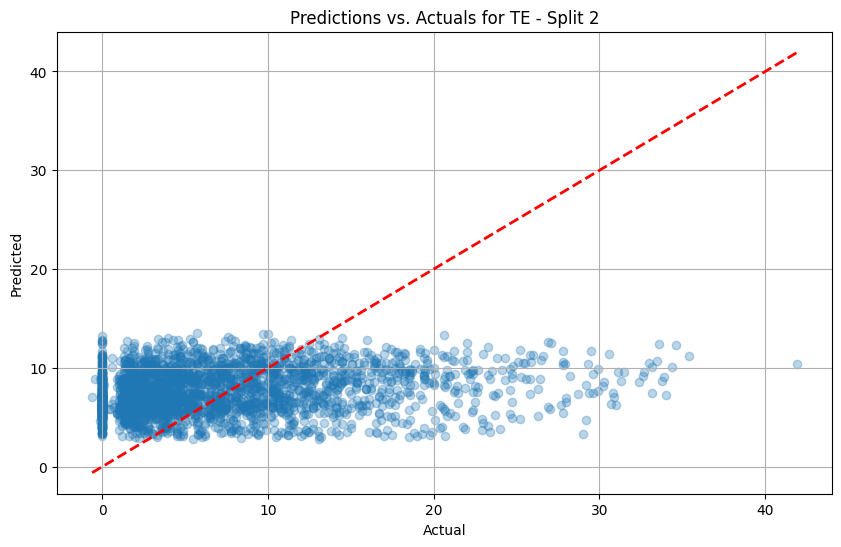

Mean Squared Error (MSE): 43.27040539580728
Mean Absolute Error (MAE): 5.247506700517069
R² Score: 0.016257968175914073
Evaluating RNN model for te - split 3...


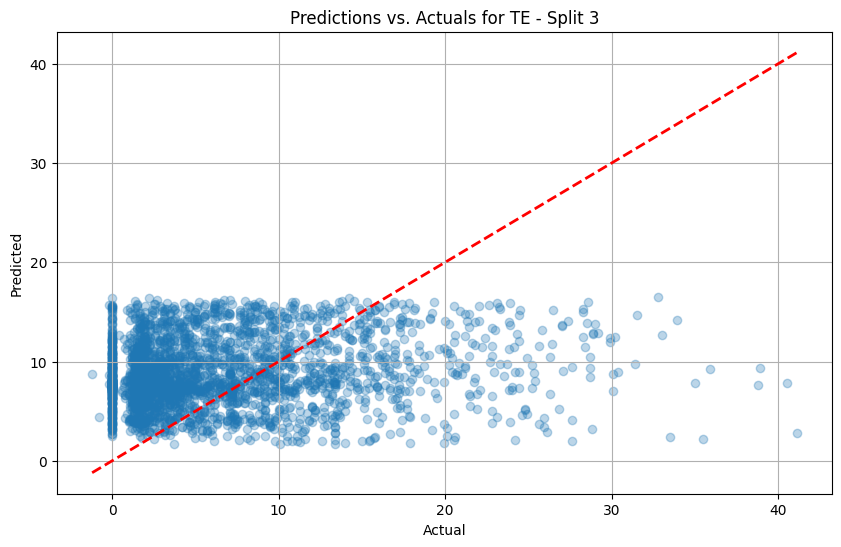

Mean Squared Error (MSE): 52.08417335427807
Mean Absolute Error (MAE): 5.949330484042627
R² Score: -0.2801065290948328
Evaluating RNN model for te - split 4...


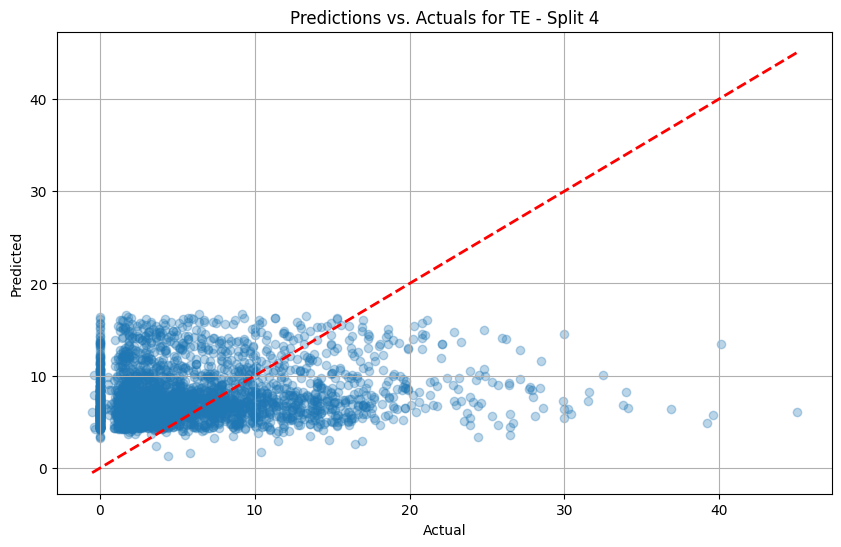

Mean Squared Error (MSE): 42.11071084537704
Mean Absolute Error (MAE): 5.189725185208905
R² Score: -0.21227972094666958
Evaluating RNN model for te - split 5...


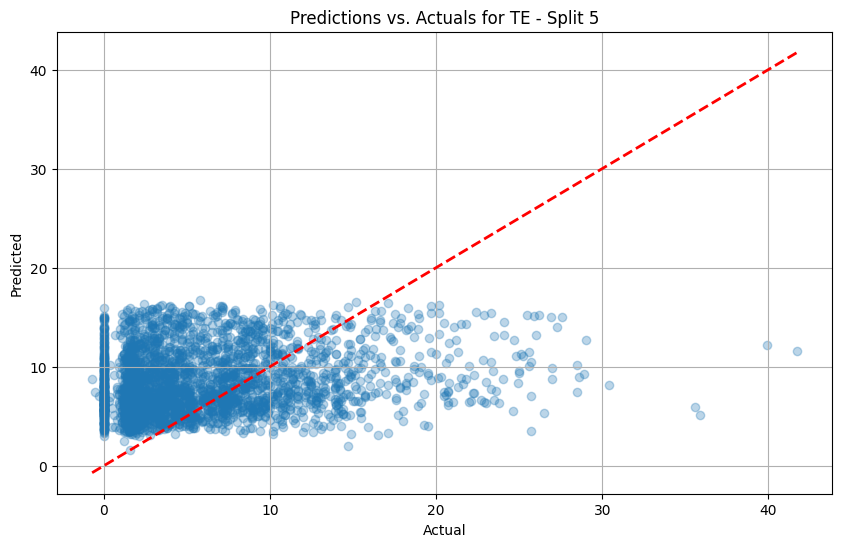

Mean Squared Error (MSE): 40.56265128310243
Mean Absolute Error (MAE): 5.206670767783458
R² Score: -0.3361984487650145
Mean Squared Error (MSE): 75.56583510591824
Mean Absolute Error (MAE): 6.9424293697466615
R² Score: -0.1167847357134848
Mean Squared Error (MSE): 73.31742341363825
Mean Absolute Error (MAE): 6.7788278962451916
R² Score: -0.16246316056730215
Mean Squared Error (MSE): 63.71761966998492
Mean Absolute Error (MAE): 6.414818828865336
R² Score: -0.1334521180882251
Mean Squared Error (MSE): 68.13528052139215
Mean Absolute Error (MAE): 6.676919854879379
R² Score: -0.13198867954418647
Mean Squared Error (MSE): 76.17231164977667
Mean Absolute Error (MAE): 7.023750864013297
R² Score: -0.06574583731557415
Mean Squared Error (MSE): 59.42895594287973
Mean Absolute Error (MAE): 5.7017195999917645
R² Score: 0.11575508343256946
Mean Squared Error (MSE): 58.10653384897368
Mean Absolute Error (MAE): 5.732512984623965
R² Score: 0.07659532376536615
Mean Squared Error (MSE): 78.6956133230146

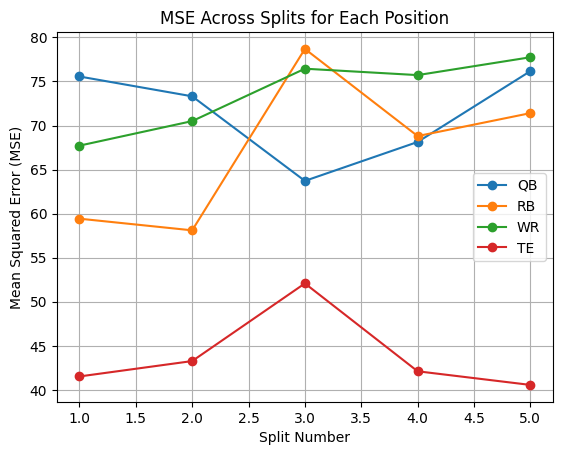

Mean Squared Error (MSE): 75.56583510591824
Mean Absolute Error (MAE): 6.9424293697466615
R² Score: -0.1167847357134848
Mean Squared Error (MSE): 73.31742341363825
Mean Absolute Error (MAE): 6.7788278962451916
R² Score: -0.16246316056730215
Mean Squared Error (MSE): 63.71761966998492
Mean Absolute Error (MAE): 6.414818828865336
R² Score: -0.1334521180882251
Mean Squared Error (MSE): 68.13528052139215
Mean Absolute Error (MAE): 6.676919854879379
R² Score: -0.13198867954418647
Mean Squared Error (MSE): 76.17231164977667
Mean Absolute Error (MAE): 7.023750864013297
R² Score: -0.06574583731557415
Mean Squared Error (MSE): 59.42895594287973
Mean Absolute Error (MAE): 5.7017195999917645
R² Score: 0.11575508343256946
Mean Squared Error (MSE): 58.10653384897368
Mean Absolute Error (MAE): 5.732512984623965
R² Score: 0.07659532376536615
Mean Squared Error (MSE): 78.69561332301467
Mean Absolute Error (MAE): 7.191372800215282
R² Score: -0.30010556560377566
Mean Squared Error (MSE): 68.804553240918

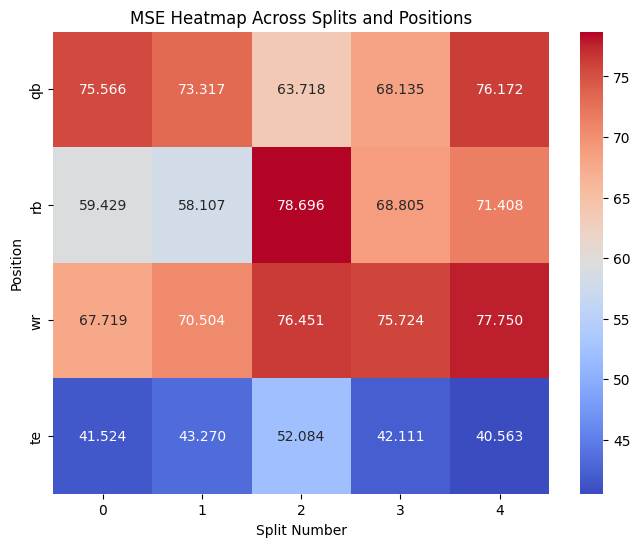

In [40]:
def plot_predictions(y_true, y_pred, key, split):
    pl.figure(figsize=(10, 6))
    pl.scatter(y_true, y_pred, alpha=0.3)
    pl.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    pl.xlabel('Actual')
    pl.ylabel('Predicted')
    pl.title(f'Predictions vs. Actuals for {key.upper()} - Split {split + 1}')
    pl.grid(True)
    pl.show()


def evaluate_predictions(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R² Score: {r2}')
    return mse, mae, r2

for key, predictions in rnn_predictions.items():
    for i, prediction in enumerate(predictions):
        dataset = normalized_datasets[key][i]
        y_true = dataset['y_test']
        y_pred = prediction

        print(f"Evaluating RNN model for {key} - split {i + 1}...")
        
        # Plot Predictions vs. Actuals
        plot_predictions(y_true, y_pred, key, i)

        # Calculate and print evaluation metrics
        mse, mae, r2 = evaluate_predictions(y_true, y_pred)

        # Optionally, store the metrics for later comparison

evaluation_results = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, predictions in rnn_predictions.items():
    for i, prediction in enumerate(predictions):
        dataset = normalized_datasets[key][i]
        y_true = dataset['y_test']
        y_pred = prediction

        mse, mae, r2 = evaluate_predictions(y_true, y_pred)
        evaluation_results[key].append((mse, mae, r2))

# Example: Plot MSE across splits for each position
for key, results in evaluation_results.items():
    mse_values = [result[0] for result in results]
    pl.plot(range(1, len(mse_values) + 1), mse_values, marker='o', label=key.upper())

pl.xlabel('Split Number')
pl.ylabel('Mean Squared Error (MSE)')
pl.title('MSE Across Splits for Each Position')
pl.legend()
pl.grid(True)
pl.show()

# Initialize the evaluation results dictionary
evaluation_results = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

# Evaluate predictions and store the MSE, MAE, R² score
for key, predictions in rnn_predictions.items():
    for i, prediction in enumerate(predictions):
        dataset = normalized_datasets[key][i]
        y_true = dataset['y_test']
        y_pred = prediction

        mse, mae, r2 = evaluate_predictions(y_true, y_pred)
        evaluation_results[key].append(mse)  # Storing only MSE for heatmap

# Convert the evaluation results into a DataFrame for heatmap plotting
import pandas as pd

# Convert evaluation results to a DataFrame
heatmap_data = pd.DataFrame(evaluation_results)

# Plot the heatmap
pl.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, annot=True, cmap='coolwarm', fmt=".3f", cbar=True)

pl.xlabel('Split Number')
pl.ylabel('Position')
pl.title('MSE Heatmap Across Splits and Positions')
pl.show()


In [41]:
def compute_permutation_importance(model, X_test, y_test, n_repeats=5):
    baseline_mse = mean_squared_error(y_test, model.predict(X_test))
    importances = np.zeros(X_test.shape[1])

    for i in range(X_test.shape[1]):
        shuffled_mses = []
        for _ in range(n_repeats):
            X_test_permuted = X_test.copy()
            np.random.shuffle(X_test_permuted[:, i])
            shuffled_mses.append(mean_squared_error(y_test, model.predict(X_test_permuted)))
        
        importances[i] = np.mean(shuffled_mses) - baseline_mse

    return importances

# Compute permutation feature importance for each model and each split
feature_importance_results = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, models in rnn_models.items():
    for i, model in enumerate(models):
        dataset = normalized_datasets[key][i]
        X_test = dataset['X_test']
        y_test = dataset['y_test']

        print(f"Computing feature importance for {key} - split {i + 1}...")
        importances = compute_permutation_importance(model, X_test, y_test)
        feature_importance_results[key].append(importances)

# Convert feature importance results to DataFrame
import pandas as pd

# Assuming all splits have the same number of features, create a DataFrame
feature_names = [f'Feature_{j}' for j in range(X_test.shape[1])]
importance_df = pd.DataFrame(np.mean(np.array([np.array(importance).T for importance in feature_importance_results[key]]), axis=0),
                             columns=feature_names)

# Plot the feature importances as a heatmap
pl.figure(figsize=(12, 8))
sns.heatmap(importance_df, annot=True, cmap='viridis', fmt=".3f", cbar=True)

pl.xlabel('Features')
pl.ylabel('Position')
pl.title('Permutation Feature Importance Heatmap')
pl.show()

Computing feature importance for qb - split 1...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Computing feature importance for qb - split 2...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61

ValueError: Shape of passed values is (3, 1), indices imply (3, 3)